# 4.查询扩展 Query Expansion

## 目录
- [4.1 - Expansion with generator answers（生成器答案扩展）](#41-expansion-with-generator-answers生成器答案扩展)
- [4.2 - Expansion with multiple queries（多个查询的查询扩展）](#42-expansion-with-multiple-queries多个查询的查询扩展)
- [4.3 - 总结](#43-总结)

我们将通过Expansion with generator answers和Expansion with multiple queries两个例子，学习使用查询增强的方法，来帮助我们改善查询的质量，提供更加精确和丰富的信息。

## 4.1  Expansion with generator answers（生成器答案扩展）


![Expansion with generated answers.png](./images/Expansion%20with%20generated%20answers.png)

我们先通过图片了解 Expansion with generator answers 的工作原理：

第一步，我们先提出一个查询。

第二步，使用LLM生成问题的答案，以提供相关上下文。

第三步，利用向量数据库（VectorDB）检索原始查询的多个结果，包含附加的上下文。

第四步，再次使用LLM得到最终答案。

让我们开始进行实践

首先，我们来导入要用到的数据

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='./data/microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

349

配置`OPENAI_API_KEY`(在`.env`文件中进行设置)

In [2]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

使用`umap`进行投影数据

In [3]:
import umap.umap_ as umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

d:\Anaconda3\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\Anaconda3\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\Anaconda3\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 

参考paper https://arxiv.org/abs/2305.03653

我们创建名为`augment`的函数，进行生成查询，并传递一个查询，传入模型参数（默认使用`gpt-3.5-turbo`），

In [4]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            # 设定一个对话场景，模型被告知扮演一个专业的财经研究助理。
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. " # 系统提示
        },
        {"role": "user", "content": query} # 通过查询作为内容
    ] 
    
    # 定义如何提示模型
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

进行第一次查询

In [5]:
original_query = "Was there significant turnover in the executive team?"
original_query_cn = "执行团队是否有重大人员流动？"
# 生成假设答案
hypothetical_answer = augment_query_generated(original_query)
# 联合查询
joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? Yes, there was
significant turnover in the executive team during the year. Three key
executives left the company, including the Chief Financial Officer,
Chief Operating Officer, and Chief Marketing Officer. The departure of
these executives resulted in a major restructuring of the executive
team with the appointment of new leaders in these roles. The company's
annual report highlights that the turnover was part of a strategic
initiative aimed at driving operational efficiency and enhancing the
company's overall performance. The new executives bring a wealth of
experience and fresh perspectives to their respective roles,
positioning the company for future growth and success.


发送一个查询和假设作为查询响应我们的检索系统。

我们接下来使用Chroma进行查询

In [6]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

the company engaged deloitte & touche llp, an independent registered
public accounting firm, to audit and render an opinion on the
consolidated financial statements and internal control over financial
reporting in accordance with the standards of the public company
accounting oversight board ( united states ). the board of directors,
through its audit committee, consisting solely of independent directors
of the company, meets periodically with management, internal auditors,
and our independent registered public accounting firm to ensure that
each is meeting its responsibilities and to discuss matters concerning
internal controls and financial reporting. deloitte & touche llp and
the internal auditors each have full and free access to the audit
committee. satya nadella chief executive officer amy e. hood executive
vice president and chief financial officer alice l. jolla corporate
vice president and chief accounting officer

89 directors and executive officers of microsoft corporation d

将查询结果集的嵌入，原始检索的嵌入，联合查询的嵌入进行投影


In [7]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


进行可视化

(-4.18140823841095, 7.548616242408753, 5.688383316993713, 13.036758685112)

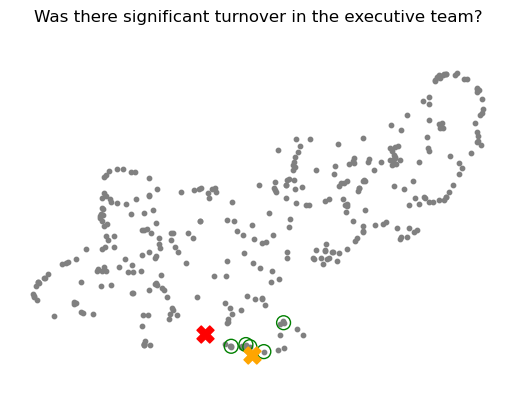

In [8]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

我们可以看到红色的`X`是我们的原始查询，橙色的`X`是我们带有假设答案的查询，绿色的圆圈是我们检索到的查询，可以看出，进行联合查询提高了我们的查询结果。

## 4.2 Expansion with multiple queries（多个查询的查询扩展）

![Expansion with multiple queries.png](./images/Expansion%20with%20multiple%20queries.png)

我们先通过图片了解 Expansion with multiple queries 的工作原理：

第一步，我们发起一个查询。

第二步，使用大型语言模型（LLM）来生成额外的查询。

第三步，这些新生成的查询被发送到向量数据库（VectorDB）。

第四步，向量数据库检索与原始查询和新查询都相关的结果。

第五步，所有的查询结果被发送回LLM。

第六步，LLM基于所有检索到的信息提供最终的答案。

与上一个方法相同（需要增加更多的系统提示）

In [9]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            # 为模型提供指令，告诉它扮演一个有用的财经研究助理。
            # 指令包括基于提供的查询生成最多五个相关的额外查询问题。
            # 提示模型生成的问题应该简短，不包含复合句，并涵盖主题的不同方面。
            # 要确保问题是完整的，并且与原始查询相关联。
            # 输出格式为每行一个问题，不要对问题编号。
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

第一次查询

In [10]:
original_query = "What were the most important factors that contributed to increases in revenue?"
original_query_cn = "推动收入增长的最重要因素是什么?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

What were the key strategies implemented to drive revenue growth?
How did changes in pricing affect revenue?
Were there any new product launches that impacted revenue growth?
Did changes in market demand play a role in revenue growth?
Were there any acquisitions or partnerships that contributed to revenue increases?


可以看到LLM生成的其他增强查询问题

收入增长的主要来源是什么？

推动收入增长的关键驱动因素是什么？

有没有特定的产品或服务推动了收入增长？

有没有收购或合作伙伴关系对收入增长做出了贡献？

支持收入增长的市场条件或趋势有哪些？


接下来，我们进行构建查询集，使用Chroma并行处理多个查询（原始查询加增强查询）并打印了每个查询及其检索到的文档。

In [11]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# 对检索到的文档进行重复数据删除
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

计算原始查询和增强查询的嵌入，然后使用`umap`将这些嵌入进行绘制投影

In [12]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


从查询结果中提取嵌入向量，使用`umap`将这些嵌入进行绘制投影

In [13]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


进行数据可视化

(-4.18140823841095, 7.548616242408753, 5.783115291595459, 13.032247638702392)

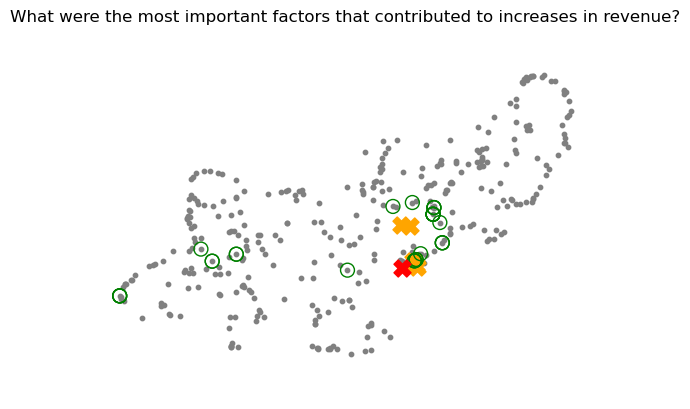

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

可以看到红色的`X`是我们的原始查询，橙色的`X`是嵌入增强的LLM生成的新查询，绿色的圆圈代表我们实际返回的结果

## 4.3 总结

通过本次Expansion with generator answers和Expansion with multiple queries两个例子，使用Chroma进行检索的增强，这对于我们找到有效的信息是非常好的。